In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
imsize = (1024,1024) 

In [27]:
original_shape = None

In [42]:
!wget https://live.staticflickr.com/3152/3071133370_bbd608d13d_o_d.jpg

--2022-03-29 09:51:11--  https://live.staticflickr.com/3152/3071133370_bbd608d13d_o_d.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 108.156.94.80, 2600:9000:203a:5800:0:5a51:64c9:c681, 2600:9000:203a:e400:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|108.156.94.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2485751 (2.4M) [image/jpeg]
Saving to: ‘3071133370_bbd608d13d_o_d.jpg’

3071133370_bbd608d1 100%[===================>]   2.37M  --.-KB/s    in 0.1s    

2022-03-29 09:51:11 (19.2 MB/s) - ‘3071133370_bbd608d13d_o_d.jpg’ saved [2485751/2485751]



In [43]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    global original_shape
    image = Image.open(image_name)
    original_shape = image.size
    print(original_shape)
    image = loader(image).unsqueeze(0)   # [B,C,H,W]
    
    return image.to(device, torch.float)
import os
os.chdir(r".")   # TO CWD (Current Working Directory) 
print(original_shape)
style_image = Image.open(r"/content/MG-1838.jpg")
content_image = Image.open(r"/content/route.jpg")
style_img = image_loader(r"/content/MG-1838.jpg")
content_img = image_loader(r"/content/route.jpg")
assert style_img.size() == content_img.size()
print(original_shape)

(700, 525)
(800, 534)
(3456, 2304)
(3456, 2304)


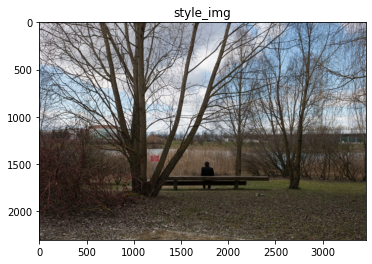

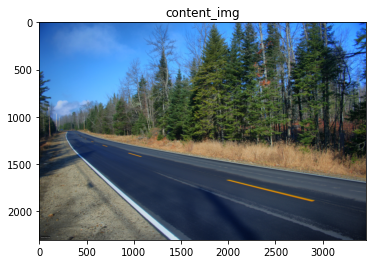

In [44]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      #  [C,H,W]
    image = unloader(image)
    image = image.resize(original_shape)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
imshow(style_img,"style_img")
imshow(content_img,"content_img")

In [45]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [46]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d) 

    G = torch.mm(features, features.t())  
    return G.div(a * b * c * d)

In [47]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature,w = 0.2):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.w = w
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)*self.w
        return input

In [48]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [49]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [50]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    print(model)
    return model, style_losses, content_losses

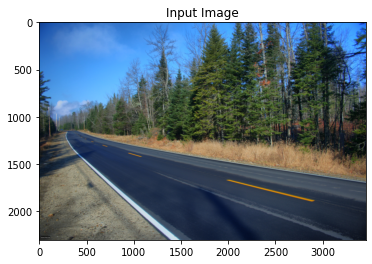

In [51]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

In [52]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [53]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
run [50]:
Style Loss : 9.720141 Content Loss: 10.302758



In [ ]:
import os
def saveimg(tensor,name):
    os.chdir("/content/") # TO OUTPUT_IMG DIRECTORY
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      #  [C,H,W]
    image = unloader(image)
    image = image.resize(original_shape)
#     print(style_image.filename[-11:-1]+"_"+content_image.filename[-11:-1])
    image.save(name)

In [ ]:
saveimg(output,"Style07Kedarnath2.jpg")